In [37]:
using Piccolo
using Optim
using LinearAlgebra
using SparseArrays
using CairoMakie

# useful
const ⊗ = kron

kron (generic function with 42 methods)

# Goals
-----
- Learn the quantum isomorphisms that map variables to real-valued state vectors
- Study how gradient descent and Newton's method can be used to optimize quantum controls. 

# I. Isomorphisms
-----

**Piccolo isomorphisms**
- The standard quantum states are _kets_, $|\psi\rangle$, and _Unitaries_, $U$.
- Open quantum system require _density matrices_, $\rho$, and _quantum channels_, $\Phi$.
- Standard quantum states have an open system counterpart,

\begin{align}
    \text{closed} &\longrightarrow \text{open}  \\ \hline
    |\psi\rangle &\longrightarrow |\psi\rangle \langle \psi | \\
    U &\longrightarrow U \cdot U^\dagger 
\end{align}

🚧 ⚠️ If you are seeing a lot of boxes like Ũ⃗, it is _very_ useful to have the [JuliaMono](https://juliamono.netlify.app/) fonts for Piccolo. Install and [change the default font family](https://code.visualstudio.com/docs/terminal/appearance).

In [2]:
# Ok, so it's not technically a wavefunction
ψ = [1; 2] + im * [3; 4]

2-element Vector{Complex{Int64}}:
 1 + 3im
 2 + 4im

In [3]:
ψ̃ = ket_to_iso(ψ)

4-element Vector{Int64}:
 1
 2
 3
 4

In [4]:
iso_to_ket(ψ̃)

2-element Vector{Complex{Int64}}:
 1 + 3im
 2 + 4im

In [5]:
# We often need to convert a complex matrix U to a real vector, Ũ⃗. 
U = [1 5; 2 6] + im * [3 7; 4 8]

2×2 Matrix{Complex{Int64}}:
 1+3im  5+7im
 2+4im  6+8im

Remember what you learned about Julia arrays! Why would I write the matrix this way?

In [6]:
Ũ⃗ = operator_to_iso_vec(U)

8-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8

In [7]:
iso_vec_to_operator(Ũ⃗)

2×2 Matrix{Complex{Int64}}:
 1+3im  5+7im
 2+4im  6+8im

Physics check: What's an efficieny that we might be able to leverage when storing $\rho$ that you don't see here?

In [8]:
# Warning: The isomorphism `density_to_iso_vec` is not the same as `operator_to_iso_vec`.
ρ = [1 2; 3 4] + im * [5 6; 7 8]
ρ̃⃗ = density_to_iso_vec(ρ)

8-element Vector{Int64}:
 1
 3
 2
 4
 5
 7
 6
 8

**Exercise** 
- Just how big are these vectors for a single qubit state? A two qubit state? 
- What about quantum channels? 

# II. Quantum dynamics
-----

**Quantum systems**

First up, we are going to look at some dynamics convenience functions in Piccolo.

- Let's flip a qubit from the ground state to the excited state.
- Introduce the isomorphisms that make quantum dynamics real-valued.  
- Use [PiccoloQuantumObjects](https://docs.harmoniqs.co/PiccoloQuantumObjects/dev/) to make a quantum system.
- Use a rollout to integrate the quantum system forward in time.

\begin{equation}
    H(u(t)) = \underbrace{u_1(t) XI + u_2(t) YI}_\text{qubit 1} 
    + \underbrace{u_3(t) IX + u_4(t) IY}_\text{qubit 2} + \underbrace{u_5(t) XX}_\text{coupling}
\end{equation}

In [10]:
H_drives = [
    PAULIS.X ⊗ PAULIS.I,
    PAULIS.Y ⊗ PAULIS.I,
    PAULIS.I ⊗ PAULIS.X,
    PAULIS.I ⊗ PAULIS.Y,
    PAULIS.X ⊗ PAULIS.X
]

system = QuantumSystem(H_drives)

QuantumSystem: levels = 4, n_drives = 5

- Quantum systems contain the operators we need, including the real valued versions.

In [11]:
get_drift(system)

4×4 SparseMatrixCSC{ComplexF64, Int64} with 0 stored entries:
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅    

- Quick check: What do we expect to see?

In [12]:
get_drives(system)[1]

4×4 SparseMatrixCSC{ComplexF64, Int64} with 4 stored entries:
     ⋅          ⋅      1.0+0.0im      ⋅    
     ⋅          ⋅          ⋅      1.0+0.0im
 1.0+0.0im      ⋅          ⋅          ⋅    
     ⋅      1.0+0.0im      ⋅          ⋅    

In [13]:
system.H(randn(system.n_drives))

4×4 SparseMatrixCSC{ComplexF64, Int64} with 12 stored entries:
           ⋅           -0.914774+2.36243im   …  -0.127443+0.0im
 -0.914774-2.36243im             ⋅              -0.461473+0.617646im
 -0.461473-0.617646im  -0.127443+0.0im          -0.914774+2.36243im
 -0.127443+0.0im       -0.461473-0.617646im               ⋅    

- Quick check: How big will this operator be?

In [14]:
system.G(randn(system.n_drives))

8×8 SparseMatrixCSC{Float64, Int64} with 40 stored entries:
   ⋅         -0.781454   -0.184787   …   0.604154   -0.267248    0.0912345
  0.781454     ⋅           ⋅              ⋅          0.0912345  -0.267248
  0.184787     ⋅           ⋅             0.0912345    ⋅          0.604154
   ⋅          0.184787    0.781454      -0.267248    0.604154     ⋅ 
   ⋅         -0.604154    0.267248      -0.781454   -0.184787     ⋅ 
 -0.604154     ⋅         -0.0912345  …    ⋅           ⋅         -0.184787
  0.267248   -0.0912345    ⋅              ⋅           ⋅         -0.781454
 -0.0912345   0.267248   -0.604154       0.184787    0.781454     ⋅ 

- We can use a system to perform a rollout.

In [15]:
# Timing information (e.g. 20 ns superconducting qubit gate)
T = 50
Δt = 0.4
timesteps = fill(Δt, T)

50-element Vector{Float64}:
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 ⋮
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4

In [16]:
# Controls
controls = randn(system.n_drives, T + 1);

In [17]:
unitary_rollout(controls, timesteps, system)

32×51 Matrix{Float64}:
 1.0   0.362594    0.374537   …  -0.347738   -0.341404     0.0569233
 0.0  -0.335931   -0.267153      -0.14916     0.0076177   -0.106456
 0.0   0.0694275  -0.0705478      0.0580262   0.235933    -0.13714
 0.0  -0.0889541  -0.132006       0.227633    0.240092     0.395226
 0.0   0.0800393   0.101647       0.508861    0.609157     0.36438
 0.0  -0.057411   -0.157797   …  -0.428834   -0.185741    -0.639016
 0.0  -0.490925   -0.479007       0.0919742  -0.110673     0.271637
 0.0  -0.701594   -0.708003       0.591902    0.593512     0.44217
 0.0  -0.736799   -0.657875       0.49032     0.646172     0.40139
 1.0   0.362274    0.464194      -0.40764     0.06851      0.188898
 ⋮                            ⋱                            ⋮
 0.0  -0.057411   -0.117888       0.0226383   0.0587887   -0.117017
 0.0   0.0126338  -0.0777252     -0.352932    0.167331     0.648602
 0.0  -0.21554    -0.243597   …  -0.473011   -0.470313     0.212379
 0.0  -0.736799   -0.66731       -0

In [18]:
# Entangling gate
U_goal = GATES.CX

# How'd we do?
println("ℱ = ", unitary_rollout_fidelity(U_goal, controls, timesteps, system))

ℱ = 0.07124879701337987


**We have all the pieces we need to solve!**

Let's put Piccolo to work.

In [19]:
# Piccolo (we'll learn more about this later)
prob = UnitarySmoothPulseProblem(system, U_goal, T, Δt);

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt


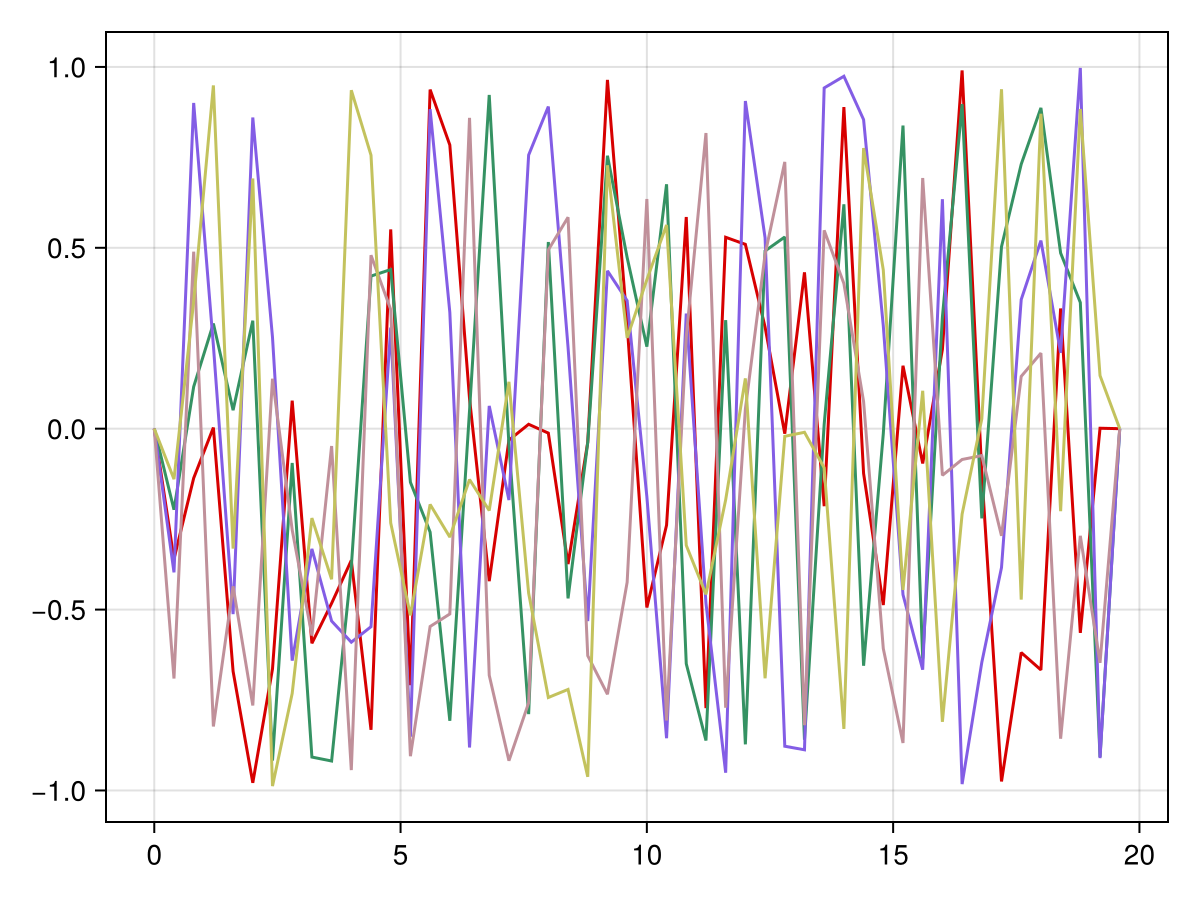

In [20]:
# save these initial controls for later
a_init = prob.trajectory.a
plot(prob.trajectory, :a)

In [21]:
solve!(
    prob, 
    max_iter=100, print_level=1, verbose=false, options=IpoptOptions(eval_hessian=false)
)

ℱ = unitary_rollout_fidelity(prob.trajectory, system)

println("The fidelity is ", ℱ)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

The fidelity is 0.9939300009864274


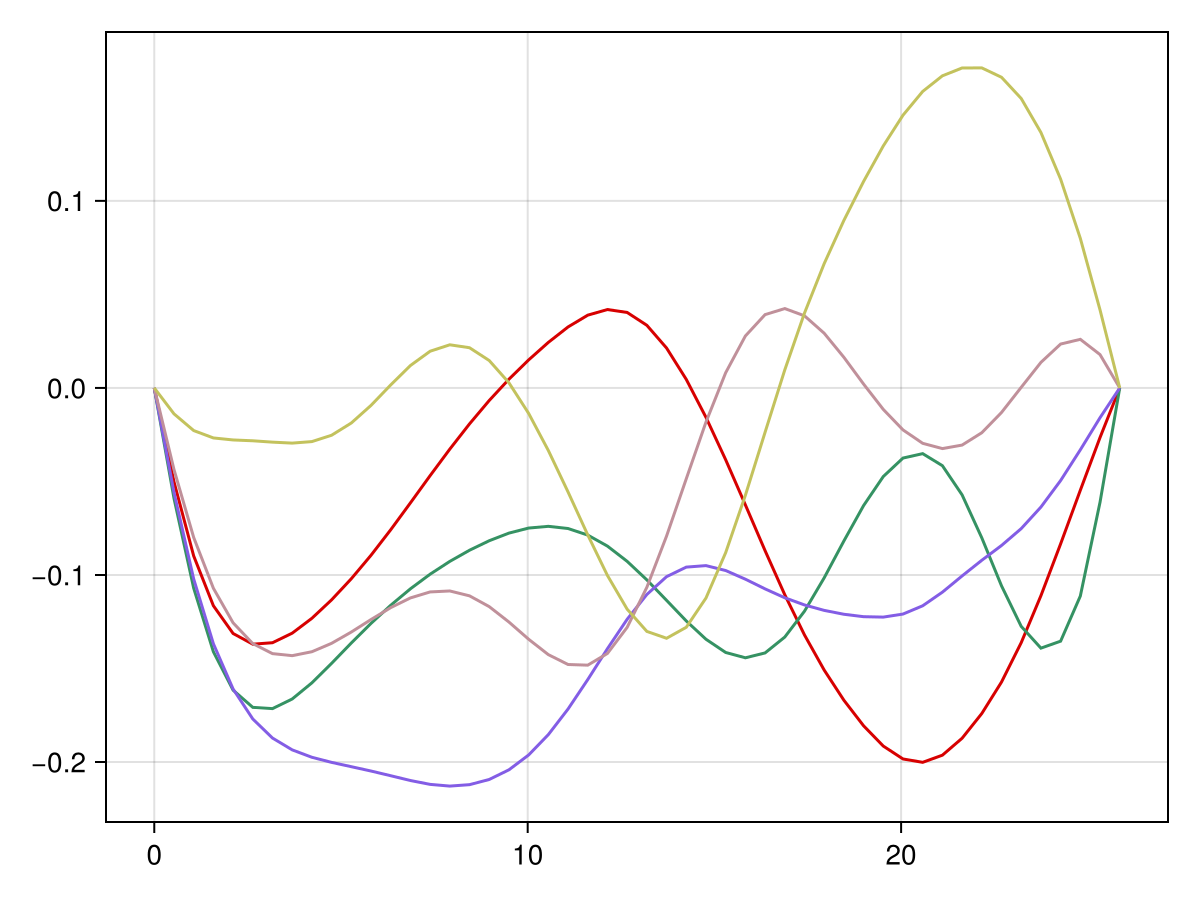

In [22]:
a_final = prob.trajectory.a
plot(prob.trajectory, :a)

# III. GRAPE
-----

The [GRAPE algorithm](https://doi.org/10.1016/j.jmr.2004.11.004) comes from NMR in 2004, and there is a [Julia version](https://github.com/JuliaQuantumControl/GRAPE.jl). We'll reproduce GRAPE in this example.

In [23]:
# We work with timesteps between knot points
timesteps = fill(Δt, T)

# Let's use our previous function to compute the fidelity
GRAPE(controls) = abs(1 - unitary_rollout_fidelity(U_goal, controls, timesteps, system))

GRAPE (generic function with 1 method)

## Automatic differentiation
- It's quick to test! Compare different algorithms, e.g., `Newton()`, `GradientDescent()`, `LBFGS()`
- If you switch from gradient descent to a quasi-Newton method, you get to [write another paper](https://www.sciencedirect.com/science/article/abs/pii/S1090780711002552).

In [24]:
result_GRAPE = optimize(GRAPE, collect(a_init), LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     8.881784e-16

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.20e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.11e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.25e-01 ≰ 0.0e+00
    |g(x)|                 = 9.08e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   59  (vs limit Inf)
    Iterations:    47
    f(x) calls:    138
    ∇f(x) calls:   138


In [25]:
a_GRAPE = Optim.minimizer(result_GRAPE)
println("The fidelity is ", unitary_rollout_fidelity(U_goal, a_GRAPE, timesteps, system))

The fidelity is 0.9999999999999991


- What do we think we'll see here?

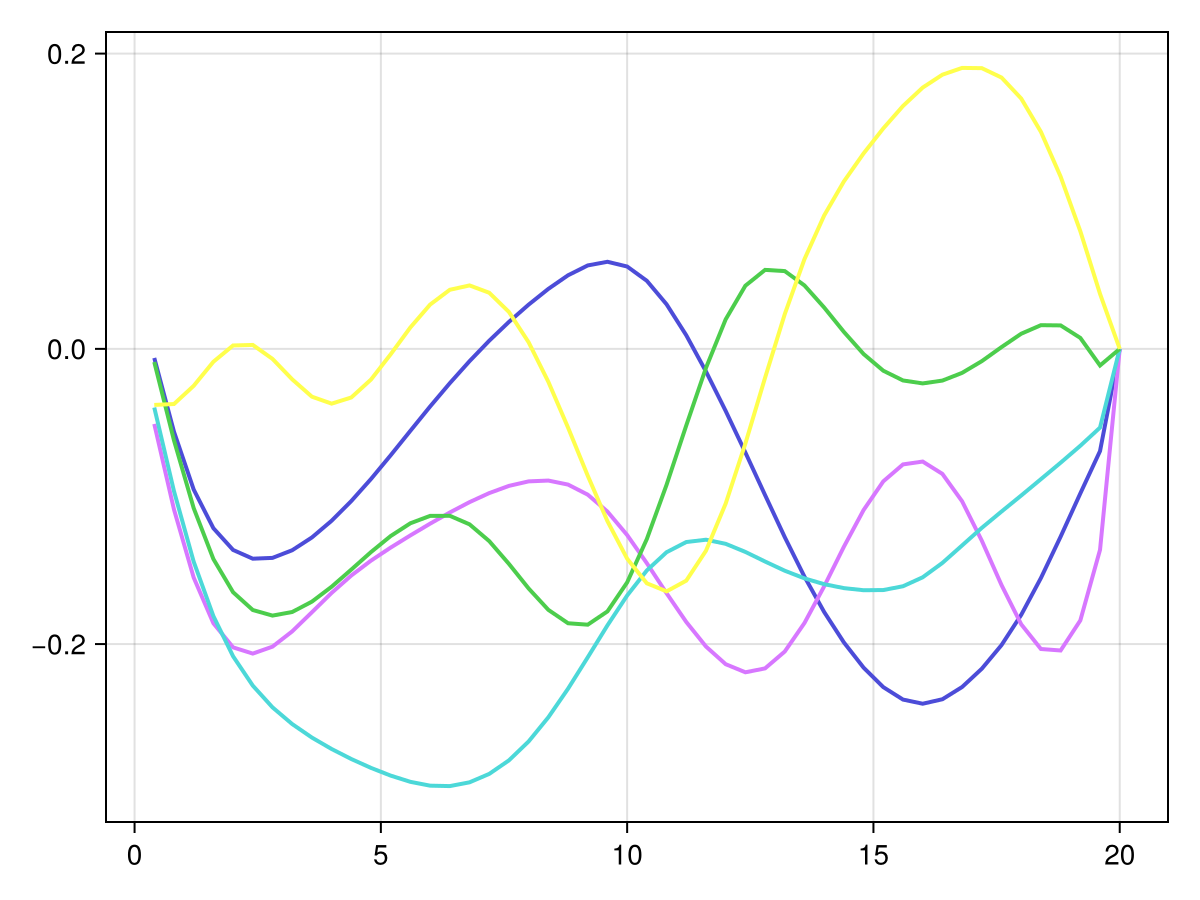

In [26]:
series(cumsum(timesteps), a_GRAPE)

## Analytic gradients

**Calculus practice**
- We can combine forward and backward rollouts to compute the gradients,
\begin{align}
    \frac{\partial U(T)}{\partial u_k(t)} &= U(T, t) (-i H_k \Delta t) U(t) \\
   \Rightarrow \langle\psi_\text{goal} | \frac{\partial U(T)}{\partial u_k(t)} |\psi_\text{init.}\rangle &= -i \Delta t \langle\psi_\text{goal}^\text{bwd.}(t) | H_k |\psi_\text{init.}^\text{fwd.}(t) \rangle.
\end{align}


**Exercise**
- Implement gradient descent using the analytic gradients.
- Sometimes, there are insights you can only get by opening up the black box, e.g. [d-GRAPE](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.042122).

# III. Function Spaces
-----

- Pick a function basis for the controls and optimize the coefficients. Some choices are [trig functions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.84.022326) or [Slepians](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.062346).
- Our optimization parameters are now coefficients of the basis,
\begin{equation}
    u(t) = u_0 + \sum_{j=1}^{n} c_j a_j(t)
\end{equation}
- The modes $a_j(t)$ stay fixed, and the coefficients $c_j$ are optimized.

In [38]:
# First n = 5 entries in a Fourier series, including the constant term
n = 5
fourier_series = [cos.(π * j * (0:T-1) / T .- π/2) for j in 0:n-1]

function get_controls(coefficients)
    a(c) = sum(cⱼ * aⱼ for (cⱼ, aⱼ) in zip(c, fourier_series))
    return stack([a(c) for c in eachrow(coefficients)], dims=1)
end

function GRAFS(coefficients)
    controls = get_controls(coefficients)
    return abs(1 - unitary_rollout_fidelity(U_goal, controls, timesteps, system))
end

GRAFS (generic function with 1 method)

In [39]:
c_init = rand(system.n_drives, n)
result_GRAFS = optimize(GRAFS, c_init, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.40e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = Inf ≰ 0.0e+00
    |g(x)|                 = 7.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    47
    f(x) calls:    260
    ∇f(x) calls:   260


In [40]:
a_GRAFS = Optim.minimizer(result_GRAFS)
println("The fidelity is ", 1 - unitary_rollout_fidelity(U_goal, a_GRAFS, timesteps, system))

The fidelity is 0.9724409335076636


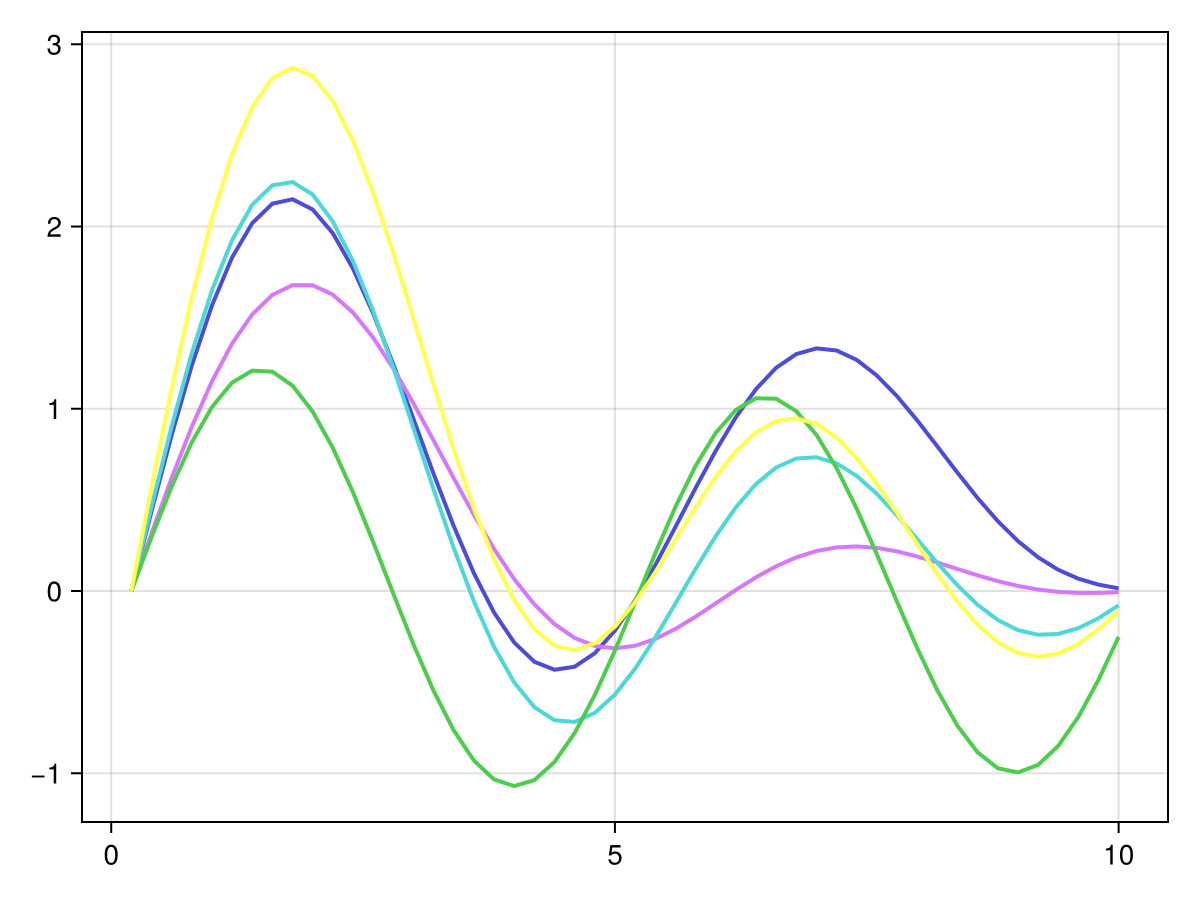

In [41]:
series(cumsum(timesteps), get_controls(a_GRAFS))

- These shapes are a lot nicer! But performance depends a lot on the expressivity and initial condition.

In [42]:
c_init = randn(system.n_drives, n)
result_GRAFS_2 = optimize(GRAFS, c_init, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     3.108624e-15

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.79e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.98e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.94e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    91
    f(x) calls:    305
    ∇f(x) calls:   305


In [43]:
a_GRAFS_2 = Optim.minimizer(result_GRAFS_2)
println("The fidelity is ", 1 - unitary_rollout_fidelity(U_goal, a_GRAFS_2, timesteps, system))

The fidelity is 0.8023708654407655


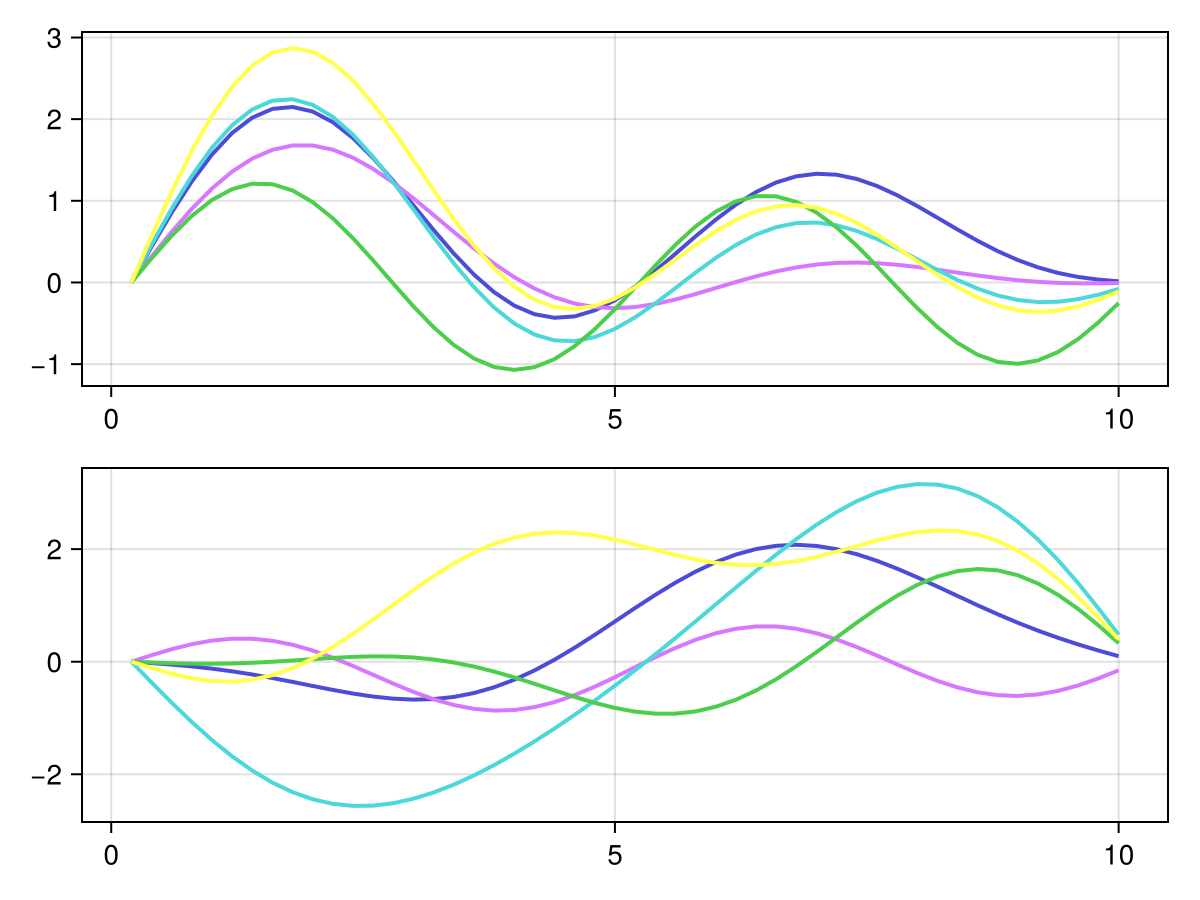

In [44]:
f = Figure()
ax = Axis(f[1,1])
series!(ax, cumsum(timesteps), get_controls(a_GRAFS))
ax = Axis(f[2,1])
series!(ax, cumsum(timesteps), get_controls(a_GRAFS_2))
f

**Exercise: A filtering approach**

- Pass the controls through a spectral filter: Look up Slepians and consider how to bound the bandwidth by choice of basis.
- How might we shape the bandwidth of the controls? (Remember, we can just rely on automatic differentiation!)

# IV. States in costs
-----

**Exercise:**

- Let's switch to a transmon, which has more than two levels and can be _leaky_.

\begin{equation}
H(u(t)) = \tfrac{1}{2} \eta a^\dagger a^\dagger a a + u_1(t) (a + a^\dagger) - i u_2(t) (a - a^\dagger)
\end{equation}

- The optimizer can exploit the higher levels!

- Add a leakage penalty to a guard state. _Notice that working with states can be awkward._

In [45]:
n = 2

2

In [46]:
a = annihilate(n)

2×2 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im
 0.0+0.0im  0.0+0.0im

In [47]:
T = 50
Δt = 0.2
timesteps = fill(Δt, T)

function Transmon(n)
    a = annihilate(n)
    x = a + a'
    p = -im * (a - a')
    η = 0.1
    return QuantumSystem(1/2 * a'a'a*a, [x, p])
end

transmon_2 = Transmon(2)
transmon_4 = Transmon(4)

QuantumSystem: levels = 4, n_drives = 2

In [48]:
function TransmonGRAFS(
    goal::AbstractPiccoloOperator, coefficients, timesteps, sys::AbstractQuantumSystem
)
    controls = get_controls(coefficients)
    return abs(1 - unitary_rollout_fidelity(goal, controls, timesteps, sys))
end

TransmonGRAFS (generic function with 1 method)

- Quick aside: _Embedded operators_

In [49]:
U_emb(n) = EmbeddedOperator(GATES.X, 1:2, n)

U_emb (generic function with 1 method)

In [50]:
U_emb(4).operator

4×4 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [51]:
unembed(U_emb(4))

2×2 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im
 1.0+0.0im  0.0+0.0im

In [57]:
n = 4

sys2, U2 = Transmon(2), U_emb(2)
c_init = randn(sys2.n_drives, n)
result_GRAFS_3 = optimize(a -> TransmonGRAFS(U2, a, timesteps, sys2), c_init, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.44e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.07e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.20e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = Inf ≰ 0.0e+00
    |g(x)|                 = 6.09e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    14
    f(x) calls:    47
    ∇f(x) calls:   47


In [58]:
a_GRAFS_3 = get_controls(Optim.minimizer(result_GRAFS_3))
println("The fidelity is ", unitary_rollout_fidelity(U2, a_GRAFS_3, timesteps, sys2))

The fidelity is 1.0


- Quick check: What might happen now?

In [59]:
println(
    "The fidelity is ", unitary_rollout_fidelity(U_emb(4), a_GRAFS_3, timesteps, Transmon(4))
)

The fidelity is 0.03408321715592492


In [55]:
# TODO: 
# - Add an L2 penalty to states that are not in the computational basis.
# - Use a modified GRAPE cost to penalize leakage while maintaining fidelity.
# - Study how leakage and fidelity change with the penalty.
# - Study how the leakage changes with the anharmonicity η.